In [1]:
pip install torchviz

In [2]:
import albumentations
import torchvision, time, os, copy
import torch.nn as nn
import torch.optim as optim
import torch, json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import cv2 as cv
import sys
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, auc, roc_curve, log_loss
from torchviz import make_dot, make_dot_from_trace
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm_notebook as tqdm
from albumentations import torch as albumentations_torch
from albumentations import Compose, GaussNoise, Resize, HorizontalFlip, Normalize

In [3]:
print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [4]:
sys.path.append('/content/drive/My Drive/Colab Notebooks/Models')

In [5]:
import CapsuleNet

In [6]:
TRAINING_DATA_FOLDER = '/content/drive/My Drive/DFDC/Training_Images'
TESTING_DATA_FOLDER = '/content/drive/My Drive/DFDC/Testing_Images'
REAL_FOLDER = 'REAL'
FAKE_FOLDER = 'FAKE'

train_list_real = list(os.listdir(os.path.join(TRAINING_DATA_FOLDER, REAL_FOLDER)))
train_list_fake = list(os.listdir(os.path.join(TRAINING_DATA_FOLDER, FAKE_FOLDER)))

In [7]:
data_transforms = Compose([
        GaussNoise(p=0.1),
        HorizontalFlip(),
        Resize(224, 224),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        albumentations_torch.ToTensor()
    ])

data_transforms_test = Compose([
        Resize(224, 224),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        albumentations_torch.ToTensor()
    ])

In [8]:
class DFDCDataset(torchvision.datasets.ImageFolder):
  def __init__(self, root, transform):
    super(DFDCDataset, self).__init__(root, transform)

  def __getitem__(self, index):
    # override ImageFolder's method
    path, target = self.samples[index]
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    if self.transform is not None:
      sample = self.transform(image=img)
    if self.target_transform is not None:
      target = self.target_transform(target)

    return sample, target

In [9]:
batch_size = 16
train_image_datasets = DFDCDataset(TRAINING_DATA_FOLDER, data_transforms)
test_image_datasets = DFDCDataset(TESTING_DATA_FOLDER, data_transforms_test)

# Creating data indices for training and validation splits:
dataset_size = len(train_image_datasets)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))
np.random.seed(322)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_image_datasets, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_image_datasets, batch_size=batch_size,
                                                sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_image_datasets, batch_size=batch_size,shuffle=True)
dataloaders = {'train': train_loader,'val':validation_loader}
dataset_sizes = {'train':len(train_loader.sampler),'val':len(validation_loader.sampler)}
class_names = train_image_datasets.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
print(dataset_size)
print(class_names)

2183
['FAKE', 'REAL']


In [10]:
# Helper function for displaying images
def imshow(images, title=None):
    # Clip just in case
    images = np.clip(images.permute(1, 2, 0), 0, 1)
    plt.imshow(images)
    plt.pause(0.001)  # pause a bit so that plots are updated

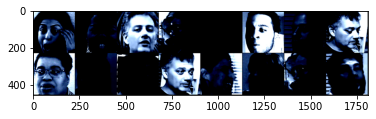

In [11]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
grid = torchvision.utils.make_grid(inputs['image'])

imshow(grid)

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    epoch_time = [] # we'll keep track of the time needed for each epoch

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for idx, (inputs, labels) in tqdm(enumerate(dataloaders[phase]),total=len(dataloaders[phase])):
                inputs = inputs['image'].to(device,dtype=torch.float)
                labels = labels.to(device,dtype=torch.float)

                # zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs, preds = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = torch.round(preds)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.unsqueeze(0))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            scheduler.step()

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        # Add the epoch time
        t_epoch = time.time() - epoch_start
        epoch_time.append(t_epoch)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_time

In [13]:
model = CapsuleNet.VggCapsule(random=True, dropout=0.05)

for param in model.CapsuleNet.parameters():
    param.requires_grad = True
criterion = CapsuleNet.CapsuleLoss()

optimizer_conv = optim.Adam(model.CapsuleNet.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model, epoch_time = train_model(model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



train Loss: 2.8484 Acc: 0.6411



val Loss: 2.8274 Acc: 0.7041
Epoch 2/25
----------



train Loss: 2.8180 Acc: 0.7401



val Loss: 2.8085 Acc: 0.7064
Epoch 3/25
----------



train Loss: 2.8023 Acc: 0.7773



val Loss: 2.8171 Acc: 0.6307
Epoch 4/25
----------



train Loss: 2.7954 Acc: 0.7894



val Loss: 2.7993 Acc: 0.7592
Epoch 5/25
----------



train Loss: 2.7876 Acc: 0.8134



val Loss: 2.7927 Acc: 0.7569
Epoch 6/25
----------



train Loss: 2.7866 Acc: 0.8100



val Loss: 2.7897 Acc: 0.7592
Epoch 7/25
----------



train Loss: 2.7845 Acc: 0.8145



val Loss: 2.7908 Acc: 0.7615
Epoch 8/25
----------



train Loss: 2.7822 Acc: 0.8168



val Loss: 2.7889 Acc: 0.7615
Epoch 9/25
----------



train Loss: 2.7826 Acc: 0.8203



val Loss: 2.7909 Acc: 0.7661
Epoch 10/25
----------



train Loss: 2.7829 Acc: 0.8151



val Loss: 2.7907 Acc: 0.7615
Epoch 11/25
----------



train Loss: 2.7804 Acc: 0.8288



val Loss: 2.7906 Acc: 0.7546
Epoch 12/25
----------



train Loss: 2.7805 Acc: 0.8191



val Loss: 2.7911 Acc: 0.7523
Epoch 13/25
----------



train Loss: 2.7828 Acc: 0.8163



val Loss: 2.7893 Acc: 0.7546
Epoch 14/25
----------



train Loss: 2.7801 Acc: 0.8237



val Loss: 2.7878 Acc: 0.7523
Epoch 15/25
----------



train Loss: 2.7812 Acc: 0.8231



val Loss: 2.7905 Acc: 0.7638
Epoch 16/25
----------



train Loss: 2.7811 Acc: 0.8180



val Loss: 2.7881 Acc: 0.7638
Epoch 17/25
----------



train Loss: 2.7825 Acc: 0.8180



val Loss: 2.7862 Acc: 0.7683
Epoch 18/25
----------



train Loss: 2.7805 Acc: 0.8237



val Loss: 2.7908 Acc: 0.7592
Epoch 19/25
----------



train Loss: 2.7824 Acc: 0.8185



val Loss: 2.7889 Acc: 0.7683
Epoch 20/25
----------



train Loss: 2.7797 Acc: 0.8243



val Loss: 2.7891 Acc: 0.7569
Epoch 21/25
----------



train Loss: 2.7803 Acc: 0.8277



val Loss: 2.7898 Acc: 0.7638
Epoch 22/25
----------



train Loss: 2.7820 Acc: 0.8208



val Loss: 2.7913 Acc: 0.7500
Epoch 23/25
----------



train Loss: 2.7817 Acc: 0.8191



val Loss: 2.7913 Acc: 0.7500
Epoch 24/25
----------



train Loss: 2.7820 Acc: 0.8168



val Loss: 2.7890 Acc: 0.7569
Epoch 25/25
----------



train Loss: 2.7828 Acc: 0.8197



val Loss: 2.7896 Acc: 0.7615
Training complete in 10m 41s
Best val Acc: 0.768349


In [14]:
predictions = []
testlabels = []
for _, (inputs, labels) in tqdm(enumerate(test_loader),total=len(test_loader)):
  inputs = inputs['image'].to(device)
  _, preds = model(inputs)
  predictions.extend(preds.cpu().detach().numpy())
  testlabels.extend(labels.cpu().detach().numpy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [15]:
log_loss(testlabels, predictions)

0.6471442206511422

In [16]:
f1_score(testlabels, np.round(predictions), average="macro")

0.6663303909205549

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


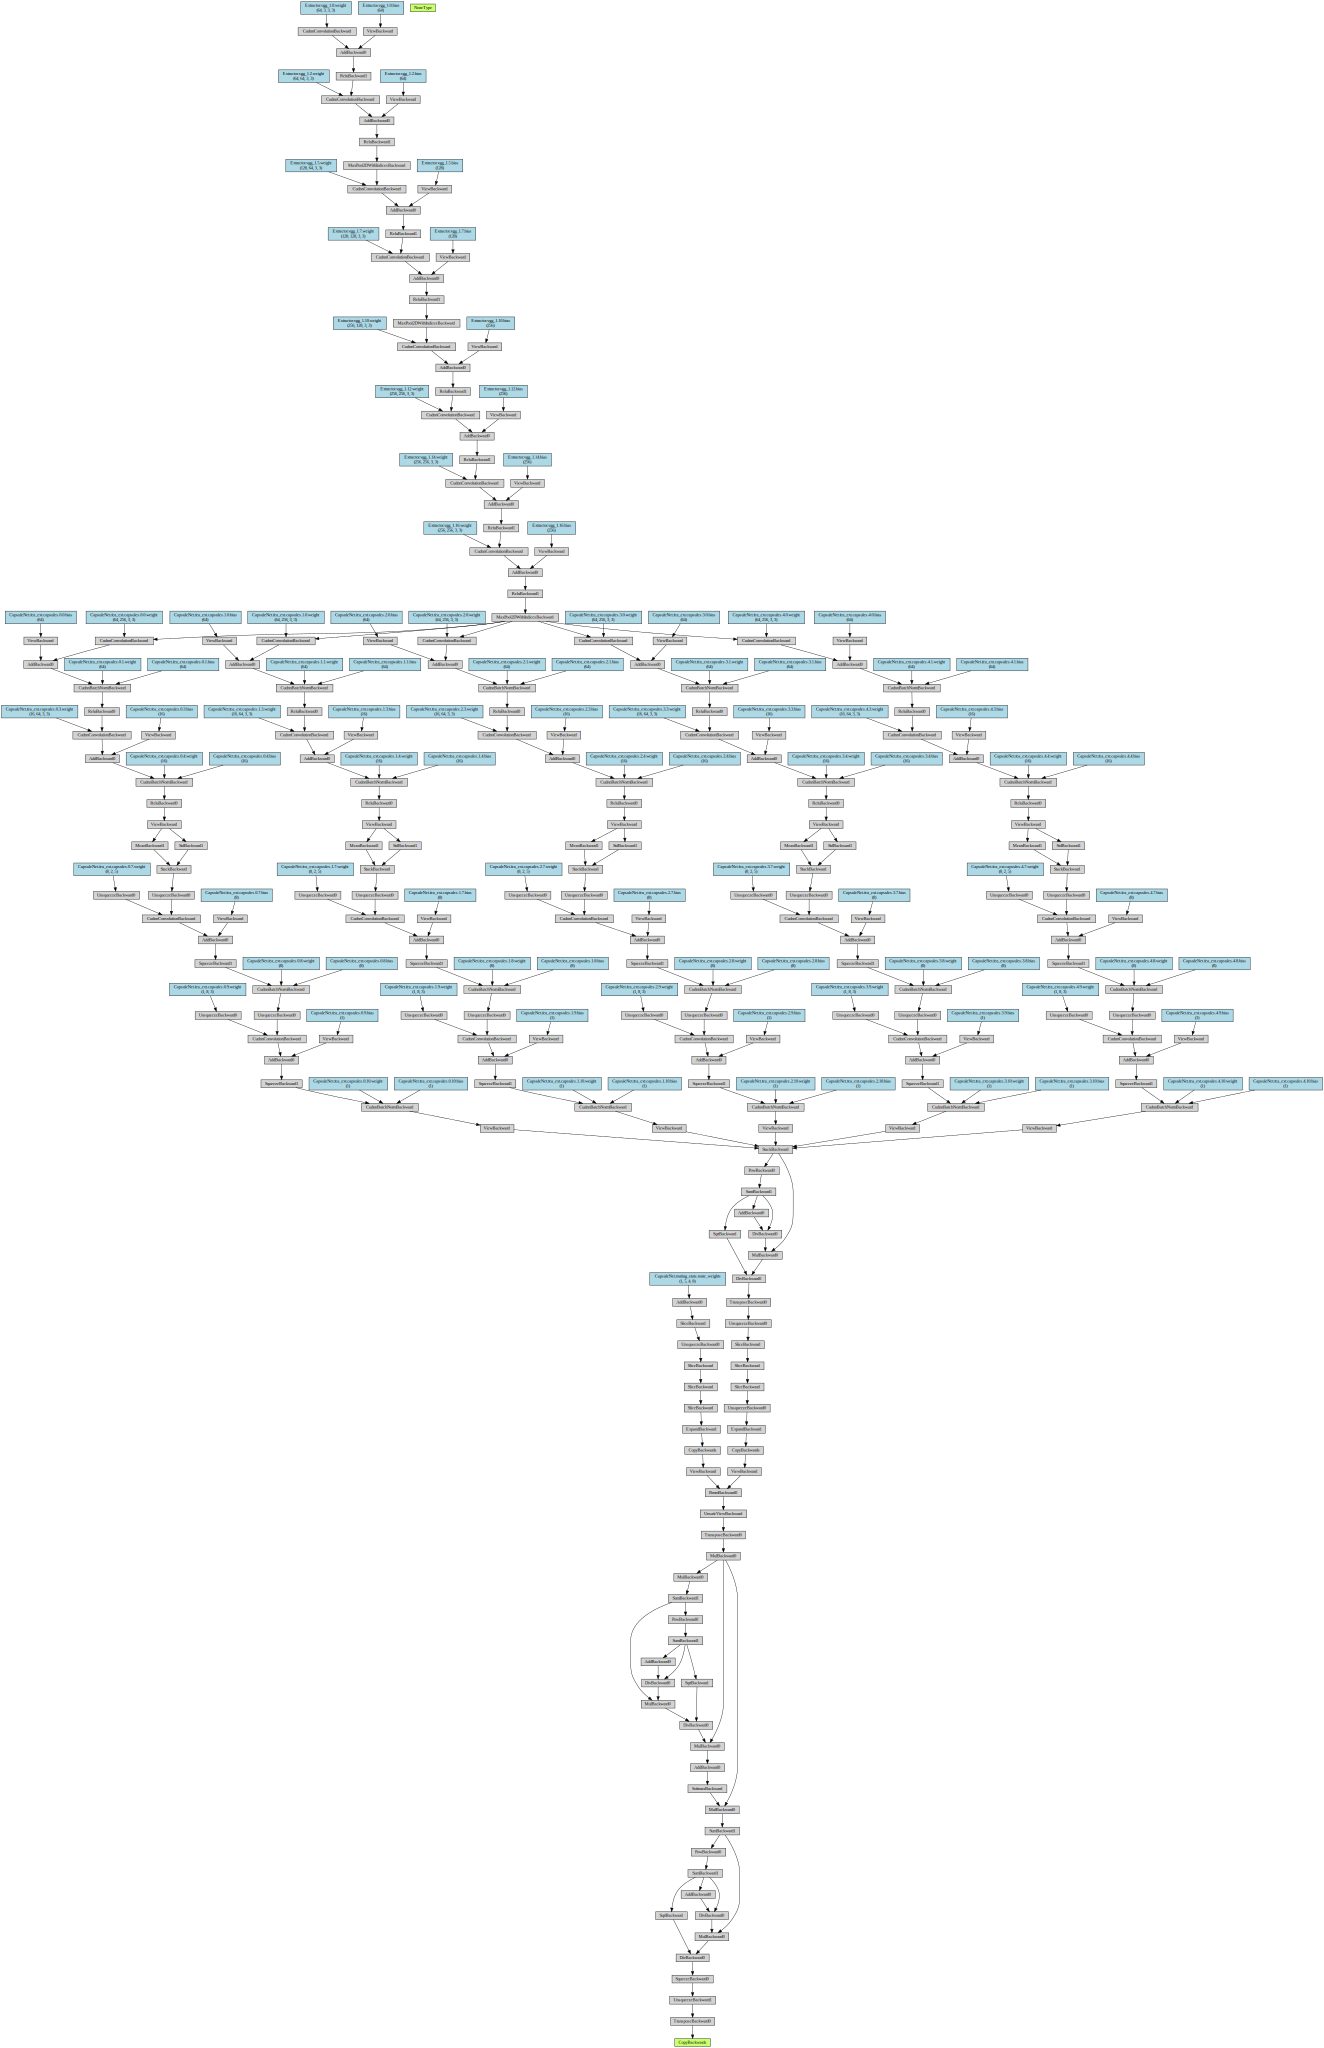

In [17]:
x, _ = next(iter(test_loader))
y = model(x['image'].to(device))
make_dot(y, params=dict(model.named_parameters()))